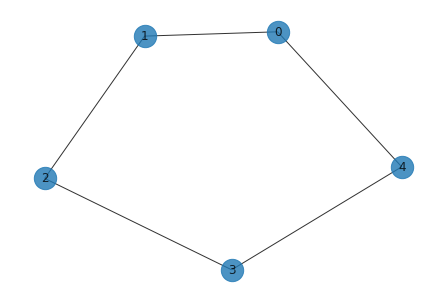

In [100]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator, Pauli

#input list indicating the connected vertices 
#and weights of edges 
#e.g. [[-5,'q0,q1'],[-3,'q1,q2'],[-1,'q2,q3'],[-2,'q0,q3']]
#define gamma, beta and p


G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
#G.add_weighted_edges_from([(0, 1,2), (1, 2,2), (2, 3,2), (3, 0,2),(0,2,1),(3,1,1)])
#G.add_weighted_edges_from([(0, 1,2), (1, 2,1), (2, 3,2), (3, 4,1),(4,5,2),(5,0,1),(5,3,1),(5,1,1),(2,0,1),(2,4,1),(0,4,1),(0,2,1),(3,5,1),(3,1,1),(1,3,1),(1,5,1)])
G.add_weighted_edges_from([(0, 1,5),(1, 2,1), (2, 3,1), (3, 4,1),(4,0,1)])
#print(G[0][1]["weight"])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)


/tmp/ipykernel_59/938895554.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


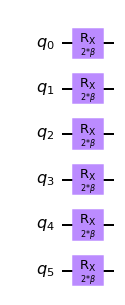

In [101]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 6

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

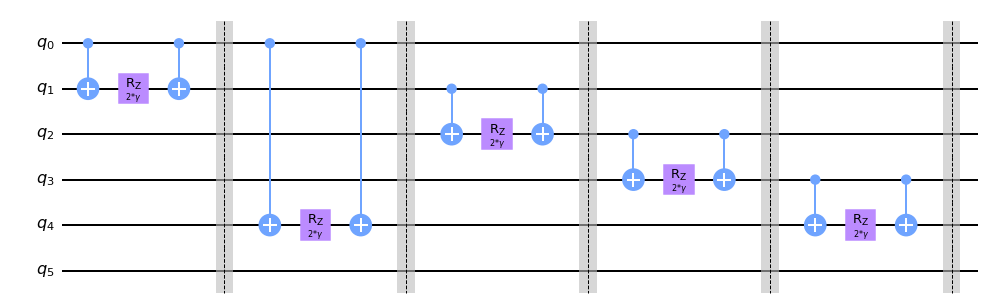

In [102]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

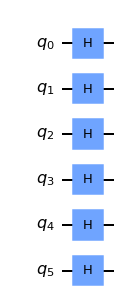

In [103]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

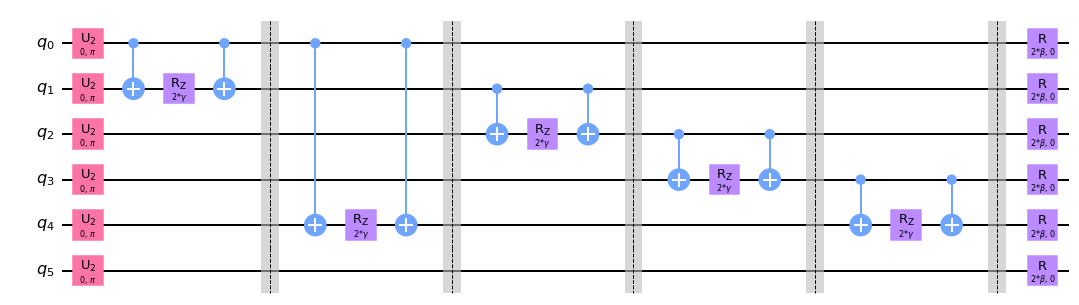

In [104]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

In [105]:
from scipy.linalg import expm
from qiskit.extensions import UnitaryGate
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= G[i][j]["weight"]
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta,M):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    string_val = "I" *  nqubits 
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep]*G[pair[0]][pair[1]]["weight"], pair[0], pair[1])

        # mixer unitary
        if M=='X0':
            for i in range(0, nqubits):
                qc.rx(2 * beta[irep], i)
        
            
        
        
        elif M=='XY':
            for pair1 in list(G.edges()):
                sigmax1 = np.array(Operator(Pauli(string_val[0:pair[0]] + 'X' + string_val[pair[0]+1: ])))
                sigmax1 = np.array(Operator(Pauli(string_val[0:pair[1]] + 'X' + string_val[pair[1]+1: ])))
                
                #sigmax2= np.array(Operator(Pauli(string_val[0:pair[1]] + 'X' + string_val[pair[1]+1:])))
                sigmay1 = np.array(Operator(Pauli(string_val[0:pair[0]] + 'Y' + string_val[pair[0]+1: ])))
                sigmay1 = np.array(Operator(Pauli(string_val[0:pair[1]] + 'Y' + string_val[pair[1]+1: ])))
                #sigmay2= np.array(Operator(Pauli(string_val[0:pair[1]] + 'Y' + string_val[pair[1]+1: ])))
                #print(sigmax1)
                #print(sigmax1.tensor(sigmax1
            
                XY_mixer=expm(2 * beta[irep]*1.0j*((sigmax1)+(sigmay1)))
                #print(UnitaryGate(XY_mixer))
                qc.append(UnitaryGate(XY_mixer),G.nodes())
                #print(XY_mixer)
                #qc.rxx(2 * beta[irep], pair[0],pair[1])
                #qc.ryy(2 * beta[irep], pair[0],pair[1])
       
            
        else:
            print('not defined')
                
    qc.measure_all()
        
    return qc
mixer='X0'
# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta,mixer)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [106]:
from scipy.optimize import minimize


expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -5.474609375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([1.99118507, 2.00658552])

In [115]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 20000

qc_res = create_qaoa_circ(G, res.x,mixer)

counts = backend.run(qc_res,
                     seed_simulator=10).result().get_counts()

plot_histogram(counts,title="5 qubit graph with weights on noise free simulator")



Traceback (most recent call last):
  File /opt/conda/lib/python3.8/site-packages/IPython/core/compilerop.py:105 in ast_parse
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
  Input In [115]
    seed_simulator=10).result().get_counts()
    ^
SyntaxError: invalid syntax

Use %tb to get the full traceback.


ibmqfactory.load_account:WARNING:2022-12-05 07:43:44,561: Credentials are already in use. The existing account in the session will be replaced.


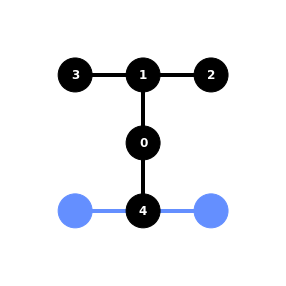

In [108]:
from qiskit.visualization import plot_circuit_layout
IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider('ibm-q')
provider.backends()
backend = provider.get_backend('ibm_oslo')

qc_res = create_qaoa_circ(G, res.x,mixer)
new_circ_lv0 = transpile(qc_res, backend=backend, optimization_level=3)
plot_circuit_layout(new_circ_lv0, backend)



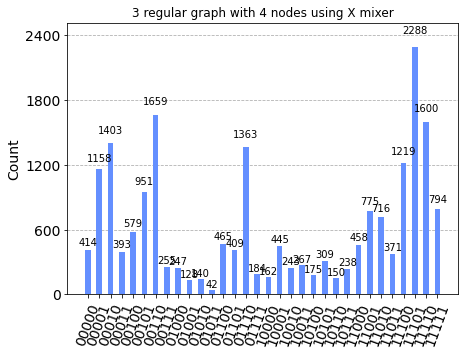

In [109]:
#layout=[0,3,4,1]
qc_trans = transpile(qc_res, backend, optimization_level=3)
job = backend.run(qc_trans, shots=20000)
output0 = job.result().get_counts()
plot_histogram(output0,title="3 regular graph with 4 nodes using X mixer")

/tmp/ipykernel_59/2827579273.py:1: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeCairo
/opt/conda/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (210788.50669687917 > 2 * 104325.12715207216). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (196328.6961892367 > 2 * 96478.49546055387). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda

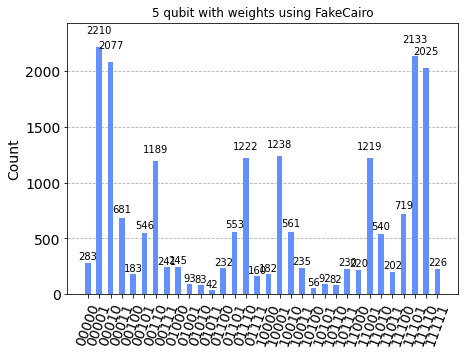

In [112]:
from qiskit.test.mock import FakeCairo
from qiskit.providers.aer import AerSimulator
backend=FakeCairo()
sim_Man = AerSimulator.from_backend(backend)
shots = 20000
t_qc = transpile(qc_res, aer_sim)
count_noise = sim_Man.run(t_qc, shots=shots).result().get_counts()

plot_histogram(count_noise,title="5 qubit with weights using FakeCairo")

In [4]:
cost_h, mixer_h = qml.qaoa.maxcut(G)

Traceback (most recent call last):
  Input In [4] in <cell line: 1>
    cost_h, mixer_h = qml.qaoa.maxcut(G)
NameError: name 'qml' is not defined

Use %tb to get the full traceback.


In [42]:
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity

from qiskit.extensions import RXGate, XGate, CXGate

print(Pauli('IIXI')*Operator(Pauli('IIXI')))

Traceback (most recent call last):
  File /opt/conda/lib/python3.8/site-packages/IPython/core/compilerop.py:105 in ast_parse
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
  Input In [42]
    print(Operator(Pauli('IIXI')*Operator(Pauli('IIXI')))
                                                         ^
SyntaxError: unexpected EOF while parsing

Use %tb to get the full traceback.


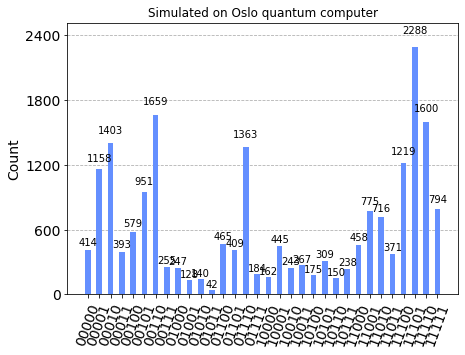

In [113]:
plot_histogram(output0,title="Simulated on Oslo quantum computer")

In [ ]:
print(